<center>
<h2>DV2599 - PROJECT</h2>
<h3>Predicting Payment date</h3>
<h4>
Rasmus Dunder - radn21@student.bth.se
</h4>
<h4>
Rasmus Johansson - rajo22@student.bth.se
</h4>
</center>

#### Import modules / libraries

In [22]:
import pandas as pd
import datetime
import math

# Ignore warnings messages in prints
import warnings
warnings.filterwarnings("ignore")

#### Data cleaning

In [ ]:
#Importing the dataset
df = pd.read_csv('dataset.csv')

#Dropping not needed columns
df = df.drop(columns=['name_customer', 'buisness_year', 'invoice_currency', 'doc_id','posting_id', 'area_business','document type', 'baseline_create_date', 'document_create_date.1', 'document_create_date'])

# df['invoice_id'] = df['invoice_id'].astype(str)
# Print ratio of open/closed invoices
not_yetpayed = df['isOpen'].value_counts().sort_index()
quality_ratios = round((not_yetpayed / not_yetpayed.sum()),4) * 100
print(f"Ratios: {quality_ratios}")
print(f"Counts: {not_yetpayed}")

# Drop all Columns where invoice is not yet paid

df_predict = df[df['isOpen'] == 1]
df = df[df['isOpen'] == 0]

#Printing the nullvalues in the dataset
print(f"\nNull values in the dataset: {sum(df.isnull().sum(axis=1))}\n")

#Dropping the nullvalues
df.dropna(inplace=True)

#Dropping the duplicates from the dataset
df.drop_duplicates(subset=['invoice_id'], inplace=True)

#Removing now not needed columns
df = df.drop(columns=['invoice_id', 'isOpen'])

#Making all dates the same type
df['due_in_date'] = pd.to_datetime(df['due_in_date'], format='%Y%m%d')
df['clear_date'] = pd.to_datetime(df['clear_date'],  errors='coerce')
df['posting_date'] = pd.to_datetime(df['posting_date'], format='%m/%d/%Y')

# Drop Columns where due_in_date is before posting date
df = df[df['due_in_date'] >= df['posting_date']]

#Creating 3 new columns
df['payment_term'] = (df['due_in_date'] - df['posting_date']).dt.days
df['delayed_payment_days'] = (df['clear_date'] - df['due_in_date']).dt.days
df['payed_on_time'] = df['delayed_payment_days'] <= 0

print(df.iloc[0:2])

Ratios: isOpen
0    80.0
1    20.0
Name: count, dtype: float64
Counts: isOpen
0    40000
1    10000
Name: count, dtype: int64

Null values in the dataset: 10006

  business_code cust_number clear_date posting_date due_in_date  \
0          U001   200769623 2020-02-11   2020-01-26  2020-02-10   
1          U001   200980828 2019-08-08   2019-07-22  2019-08-11   

   total_open_amount cust_payment_terms  payment_term  delayed_payment_days  \
0           54273.28               NAH4            15                     1   
1           79656.60               NAD1            20                    -3   

   payed_on_time  
0          False  
1           True  


Att tänka på

- Outliers
- Normalisering

In [ ]:
from scipy import stats
from sklearn.preprocessing import LabelEncoder

#Checking for ratio on True/False
payed_time = df['payed_on_time'].value_counts().sort_index()
quality_ratios = round((payed_time / payed_time.sum()),4) * 100
print(f"Ratios: {quality_ratios}")
print(f"Counts: {payed_time}")

# Checking for outliers
df_zscore = df.copy()
df_zscore['Z-score']= stats.zscore(df_zscore['delayed_payment_days']) #Calculating z-score for Value
threshold = 3
df_icu_zscore = df_zscore [abs(df_zscore ['Z-score']) > threshold]
print("Number of outliers on Value", df_icu_zscore['delayed_payment_days'].count())
zscore_min = abs(df_icu_zscore['delayed_payment_days']).min()
zscore_max = abs(df_icu_zscore['delayed_payment_days']).max()
print(f"Outlier value range: Min = {zscore_min}, Max = {zscore_max}")

label_encoder = LabelEncoder()
df['cust_number'] = label_encoder.fit_transform(df['cust_number'])
label_encoder = LabelEncoder()
df['cust_payment_terms'] = label_encoder.fit_transform(df['cust_payment_terms'])

df_payement_days = df.copy()
df_payement_ontime = df.copy()

df_payement_days = df_payement_days.drop(columns=['payed_on_time'])
df_payement_ontime = df_payement_ontime.drop(columns=['delayed_payment_days'])

Ratios: payed_on_time
False    41.76
True     58.24
Name: count, dtype: float64
Counts: payed_on_time
False    16308
True     22740
Name: count, dtype: int64
Ratios: delayed_payment_days
-89     0.00
-87     0.00
-79     0.00
-75     0.01
-74     0.01
        ... 
 157    0.00
 171    0.00
 195    0.00
 202    0.00
 204    0.00
Name: count, Length: 175, dtype: float64
Counts: delayed_payment_days
-89     1
-87     1
-79     1
-75     5
-74     5
       ..
 157    1
 171    1
 195    1
 202    1
 204    1
Name: count, Length: 175, dtype: int64
Number of outliers on Value 1018
Outlier value range: Min = 32, Max = 204


### Splitting and Scaling of the data

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
print(list(df_payement_ontime.columns))

#df_payement_ontime = df_payement_ontime[df_payement_ontime['business_code'] == 'U013']

unique_business_codes = df_payement_ontime['business_code'].unique()
print("Unique Business Codes:", unique_business_codes)
label_encoder = LabelEncoder()
df_payement_ontime['business_code'] = label_encoder.fit_transform(df_payement_ontime['business_code'])

label_encoder = LabelEncoder()
df_payement_ontime['payed_on_time'] = label_encoder.fit_transform(df_payement_ontime['payed_on_time'])

mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping of business codes to numbers:", mapping)

# Divide the data into X and y compontents, X being all the attributes and y being the outcome.
X = df_payement_ontime.iloc[:, :-1]
y = df_payement_ontime.iloc[:,-1:]

# Split data
date_X_train, date_X_test, date_y_train, date_y_test = train_test_split(X ,y ,test_size = 0.30, random_state=0)
secs_X_train, secs_X_test, secs_y_train, secs_y_test = train_test_split(X ,y ,test_size = 0.30, random_state=0)

for col in ['posting_date', 'due_in_date', 'clear_date']:
    date_X_train[f'{col}_year'] = date_X_train[col].dt.year
    date_X_train[f'{col}_month'] = date_X_train[col].dt.month
    date_X_train[f'{col}_day'] = date_X_train[col].dt.day

    date_X_test[f'{col}_year'] = date_X_test[col].dt.year
    date_X_test[f'{col}_month'] = date_X_test[col].dt.month
    date_X_test[f'{col}_day'] = date_X_test[col].dt.day

# Drop the original date columns if no longer needed
date_X_train.drop(columns=['posting_date', 'due_in_date', 'clear_date'], inplace=True)
date_X_test.drop(columns=['posting_date', 'due_in_date', 'clear_date'], inplace=True)

#MIN MAX SCALING
scaler = MinMaxScaler()
columns = ['payment_term', 'total_open_amount']
scaled_values_train = scaler.fit_transform(date_X_train[columns])
scaled_values_test = scaler.transform(date_X_test[columns])

X_train_scaled = date_X_train.copy()
X_test_scaled = date_X_test.copy()

secs_X_train['posting_date'] = secs_X_train['posting_date'].astype('int64') // 10**9
secs_X_test['posting_date'] = secs_X_test['posting_date'].astype('int64') // 10**9
secs_X_train['due_in_date'] = secs_X_train['due_in_date'].astype('int64') // 10**9
secs_X_test['due_in_date'] = secs_X_test['due_in_date'].astype('int64') // 10**9
secs_X_train['clear_date'] = secs_X_train['clear_date'].astype('int64') // 10**9
secs_X_test['clear_date'] = secs_X_test['clear_date'].astype('int64') // 10**9

#Add the scaled columns to the DataFrame with new column names
for i, col in enumerate(columns):
    X_train_scaled[f"{col}"] = scaled_values_train[:, i]
    X_test_scaled[f"{col}"] = scaled_values_test[:, i]

for column in X_train_scaled.columns:
    if X_train_scaled[column].dtype in ['int64', 'float64']:
        min_value = X_train_scaled[column].min()
        max_value = X_train_scaled[column].max()
        print(f"Column: {column}, Range: ({min_value}, {max_value})")
    else:
        unique_values = X_train_scaled[column].nunique()
        print(f"Column: {column} is non-numeric with {unique_values} unique values.")




print((df.groupby('business_code')['payed_on_time'].value_counts(normalize=True).unstack()*100).round(2))

#Checking for ratio on business_code
payed_time = df['business_code'].value_counts().sort_index()
quality_ratios = round((payed_time / payed_time.sum()),4) * 100
#print(f"Ratios: {quality_ratios}")
print(f"Counts: {payed_time}")



['business_code', 'cust_number', 'clear_date', 'posting_date', 'due_in_date', 'total_open_amount', 'cust_payment_terms', 'payment_term', 'payed_on_time']
Unique Business Codes: ['U001' 'CA02' 'U013' 'U002' 'U007' 'U005']
Mapping of business codes to numbers: {False: 0, True: 1}
Column: business_code is non-numeric with 6 unique values.
Column: cust_number is non-numeric with 933 unique values.
Column: total_open_amount, Range: (0.0, 1.0)
Column: cust_payment_terms is non-numeric with 69 unique values.
Column: payment_term, Range: (0.0, 1.0)
Column: posting_date_year is non-numeric with 3 unique values.
Column: posting_date_month is non-numeric with 12 unique values.
Column: posting_date_day is non-numeric with 31 unique values.
Column: due_in_date_year is non-numeric with 3 unique values.
Column: due_in_date_month is non-numeric with 12 unique values.
Column: due_in_date_day is non-numeric with 31 unique values.
Column: clear_date_year is non-numeric with 2 unique values.
Column: clear

### Performing KFold validations tests

##### Dates as month/day/year

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import RepeatedKFold, cross_val_score

import numpy as np

rkf = RepeatedKFold(n_splits= 2, n_repeats= 5)
date_knn_f1_scores = cross_val_score(KNeighborsClassifier(), X_train_scaled, date_y_train, cv= rkf, scoring="f1")
date_rdf_f1_scores = cross_val_score(RandomForestClassifier(), X_train_scaled, date_y_train, cv= rkf, scoring="f1")
date_gdb_f1_scores = cross_val_score(GradientBoostingClassifier(), X_train_scaled, date_y_train, cv= rkf, scoring="f1")

#Rounds all scores to 4 decimals
for i,x in enumerate(date_gdb_f1_scores):
    date_gdb_f1_scores[i] = round(x,4)

for i,x in enumerate(date_rdf_f1_scores):
    date_rdf_f1_scores[i] = round(x,4)

for i,x in enumerate(date_knn_f1_scores):
    date_knn_f1_scores[i] = round(x,4)

## Calculating mean and standard deviation
date_knn_mean_f1 = round(sum(date_knn_f1_scores)/len(date_knn_f1_scores),4)
date_rdf_mean_f1 = round(sum(date_rdf_f1_scores)/len(date_rdf_f1_scores),4)
date_gdb_mean_f1 = round(sum(date_gdb_f1_scores)/len(date_gdb_f1_scores),4)
date_knn_std_deviation_f1 = round(np.std(date_knn_f1_scores),4)
date_rdf_std_deviation_f1 = round(np.std(date_rdf_f1_scores),4)
date_gdb_std_deviation_f1 = round(np.std(date_gdb_f1_scores),4)

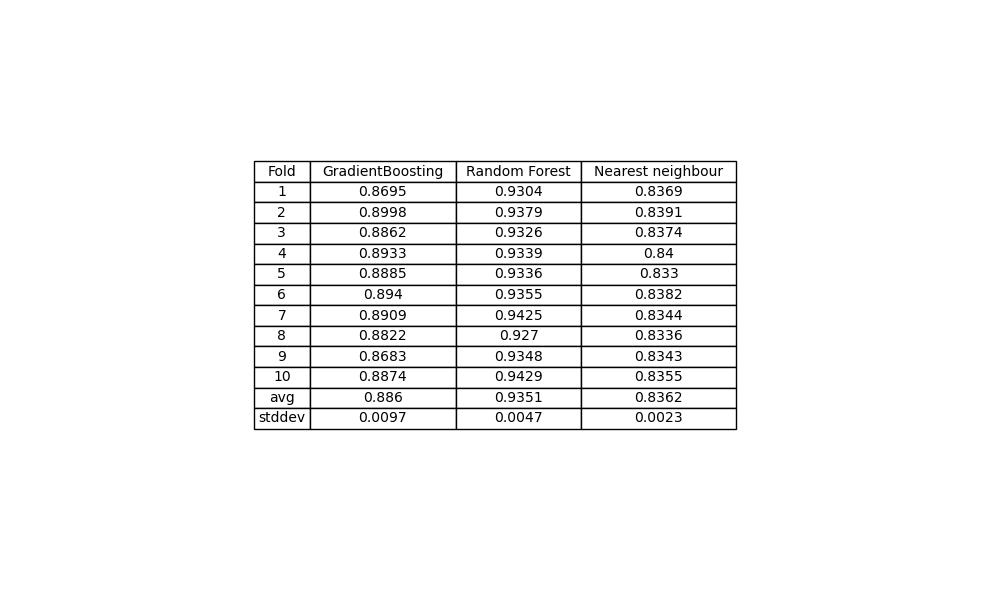

In [27]:
import matplotlib.pyplot as plt

## Making a new Dataframe that looks like table 12.4 in main literature
data = {
    'Fold': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'GradientBoosting': date_gdb_f1_scores,
    'Random Forest': date_rdf_f1_scores,
    'Nearest neighbour': date_knn_f1_scores,
}
avg = ['avg',date_gdb_mean_f1,date_rdf_mean_f1,date_knn_mean_f1]
stddev = ['stddev',date_gdb_std_deviation_f1,date_rdf_std_deviation_f1,date_knn_std_deviation_f1]


plot = pd.DataFrame(data)
plot.loc[len(plot)] = avg
plot.loc[len(plot)] = stddev

## Plot the dataframe as a Table
fig, ax = plt.subplots(figsize=(10, 6))

fig.patch.set_visible(False)
ax.axis('off')
table = ax.table(cellText=plot.values, colLabels=plot.columns, loc='center', cellLoc='center')
fig.tight_layout()
table.auto_set_column_width(col=list(range(len(plot.columns))))

##### Dates as seconds from January 1970

In [28]:
rkf = RepeatedKFold(n_splits= 2, n_repeats= 5)
secs_knn_f1_scores = cross_val_score(KNeighborsClassifier(), secs_X_train, secs_y_train, cv= rkf, scoring="f1")
secs_rdf_f1_scores = cross_val_score(RandomForestClassifier(), secs_X_train, secs_y_train, cv= rkf, scoring="f1")
secs_gdb_f1_scores = cross_val_score(GradientBoostingClassifier(), secs_X_train, secs_y_train, cv= rkf, scoring="f1")

#Rounds all scores to 4 decimals
for i,x in enumerate(secs_gdb_f1_scores):
    secs_gdb_f1_scores[i] = round(x,4)

for i,x in enumerate(secs_rdf_f1_scores):
    secs_rdf_f1_scores[i] = round(x,4)

for i,x in enumerate(secs_knn_f1_scores):
    secs_knn_f1_scores[i] = round(x,4)

## Calculating mean and standard deviation
secs_knn_mean_f1 = round(sum(secs_knn_f1_scores)/len(secs_knn_f1_scores),4)
secs_rdf_mean_f1 = round(sum(secs_rdf_f1_scores)/len(secs_rdf_f1_scores),4)
secs_gdb_mean_f1 = round(sum(secs_gdb_f1_scores)/len(secs_gdb_f1_scores),4)
secs_knn_std_deviation_f1 = round(np.std(secs_knn_f1_scores),4)
secs_rdf_std_deviation_f1 = round(np.std(secs_rdf_f1_scores),4)
secs_gdb_std_deviation_f1 = round(np.std(secs_gdb_f1_scores),4)

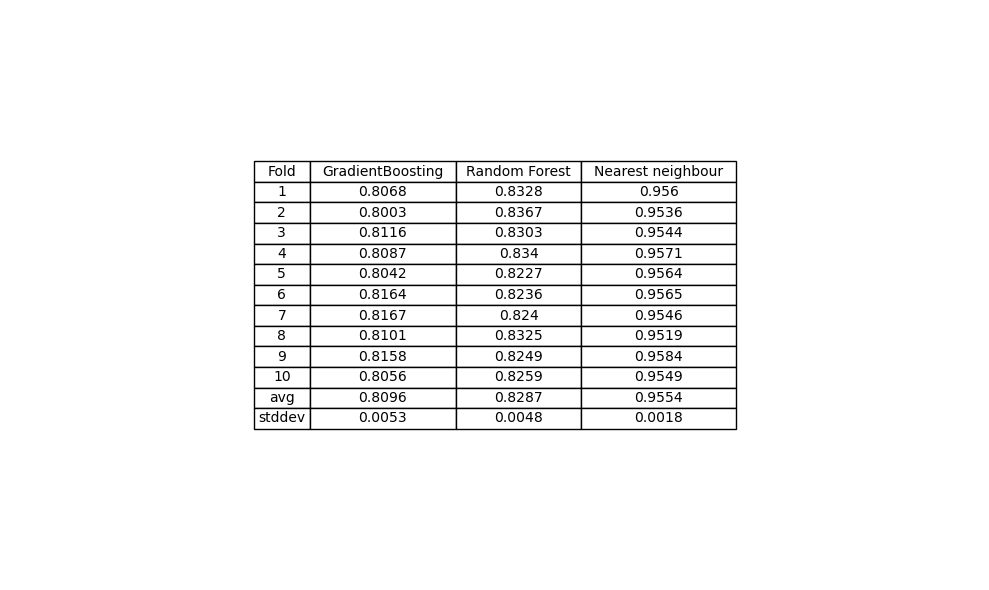

In [29]:
## Making a new Dataframe that looks like table 12.4 in main literature
data = {
    'Fold': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'GradientBoosting': secs_gdb_f1_scores,
    'Random Forest': secs_rdf_f1_scores,
    'Nearest neighbour': secs_knn_f1_scores,
}
avg = ['avg',secs_gdb_mean_f1,secs_rdf_mean_f1,secs_knn_mean_f1]
stddev = ['stddev',secs_gdb_std_deviation_f1,secs_rdf_std_deviation_f1,secs_knn_std_deviation_f1]


plot = pd.DataFrame(data)
plot.loc[len(plot)] = avg
plot.loc[len(plot)] = stddev

## Plot the dataframe as a Table
fig, ax = plt.subplots(figsize=(10, 6))

fig.patch.set_visible(False)
ax.axis('off')
table = ax.table(cellText=plot.values, colLabels=plot.columns, loc='center', cellLoc='center')
fig.tight_layout()
table.auto_set_column_width(col=list(range(len(plot.columns))))

### Ranking the tests and plotting ranktables

##### Dates as month/day/year

In [34]:
ranks = []


## Checking wich algorithms has the highest, middle and lowest value for each fold
for i in range(len(date_knn_f1_scores)):
    
    knn = date_knn_f1_scores[i]
    rdf = date_rdf_f1_scores[i]
    gdb = date_gdb_f1_scores[i]
    
    if knn >= rdf and knn >= gdb:
        knn_rank = 1
        if rdf >= gdb:
            rdf_rank = 2
            gdb_rank = 3
        else:
            rdf_rank = 3
            gdb_rank = 2
    elif rdf >= knn and rdf >= gdb:
        rdf_rank = 1
        if knn >= gdb:
            knn_rank = 2
            gdb_rank = 3
        else:
            knn_rank = 3
            gdb_rank = 2
    else:
        gdb_rank = 1
        if knn >= rdf:
            knn_rank = 2
            rdf_rank = 3
        else:
            knn_rank = 3
            rdf_rank = 2

    ranks.append([gdb_rank,rdf_rank,knn_rank])

## Calculating a average rank

date_avg_knn_f1_scores = 0
date_avg_rdf_f1_scores = 0
date_avg_gdb_f1_scores = 0

for x in ranks:
    date_avg_gdb_f1_scores += x[0]
    date_avg_rdf_f1_scores += x[1]
    date_avg_knn_f1_scores += x[2]

date_avg_gdb_f1_scores = date_avg_gdb_f1_scores/len(ranks)
date_avg_rdf_f1_scores = date_avg_rdf_f1_scores/len(ranks)
date_avg_knn_f1_scores = date_avg_knn_f1_scores/len(ranks)

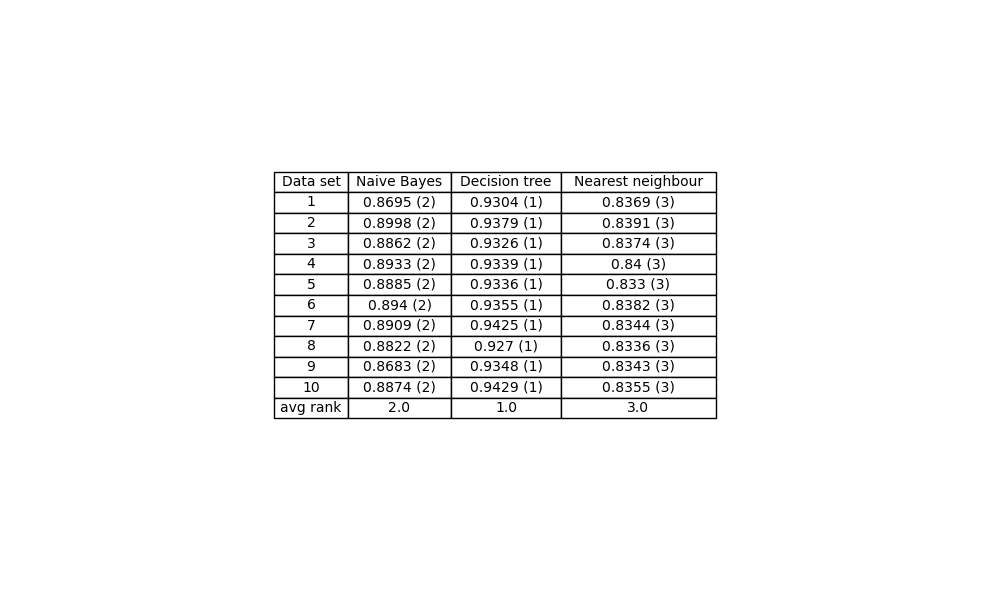

In [35]:
## Making a new Dataframe that looks like table 12.8 in main literature

gdb_string = []
rdf_string = []
knn_string = []

for i in range(len(ranks)):
    gdb_string.append(str(date_gdb_f1_scores[i]) + " (" + str(ranks[i][0]) + ")")
    rdf_string.append(str(date_rdf_f1_scores[i]) + " (" + str(ranks[i][1]) + ")")
    knn_string.append(str(date_knn_f1_scores[i]) + " (" + str(ranks[i][2]) + ")")


data = {
    'Data set': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Naive Bayes': gdb_string,
    'Decision tree': rdf_string,
    'Nearest neighbour': knn_string,
}
avg = ['avg rank',date_avg_gdb_f1_scores,date_avg_rdf_f1_scores,date_avg_knn_f1_scores]

plot = pd.DataFrame(data)
plot.loc[len(plot)] = avg

## Plotting the dataframe as a Table

fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_visible(False)
ax.axis('off')
table = ax.table(cellText=plot.values, colLabels=plot.columns, loc='center', cellLoc='center')
fig.tight_layout()
table.auto_set_column_width(col=list(range(len(plot.columns))))

##### Dates as seconds from January 1970

In [36]:
ranks = []


## Checking wich algorithms has the highest, middle and lowest value for each fold
for i in range(len(secs_knn_f1_scores)):
    
    knn = secs_knn_f1_scores[i]
    rdf = secs_rdf_f1_scores[i]
    gdb = secs_gdb_f1_scores[i]
    
    if knn >= rdf and knn >= gdb:
        knn_rank = 1
        if rdf >= gdb:
            rdf_rank = 2
            gdb_rank = 3
        else:
            rdf_rank = 3
            gdb_rank = 2
    elif rdf >= knn and rdf >= gdb:
        rdf_rank = 1
        if knn >= gdb:
            knn_rank = 2
            gdb_rank = 3
        else:
            knn_rank = 3
            gdb_rank = 2
    else:
        gdb_rank = 1
        if knn >= rdf:
            knn_rank = 2
            rdf_rank = 3
        else:
            knn_rank = 3
            rdf_rank = 2

    ranks.append([gdb_rank,rdf_rank,knn_rank])

## Calculating a average rank

secs_avg_knn_f1_scores = 0
secs_avg_rdf_f1_scores = 0
secs_avg_gdb_f1_scores = 0

for x in ranks:
    secs_avg_gdb_f1_scores += x[0]
    secs_avg_rdf_f1_scores += x[1]
    secs_avg_knn_f1_scores += x[2]

secs_avg_gdb_f1_scores = secs_avg_gdb_f1_scores/len(ranks)
secs_avg_rdf_f1_scores = secs_avg_rdf_f1_scores/len(ranks)
secs_avg_knn_f1_scores = secs_avg_knn_f1_scores/len(ranks)

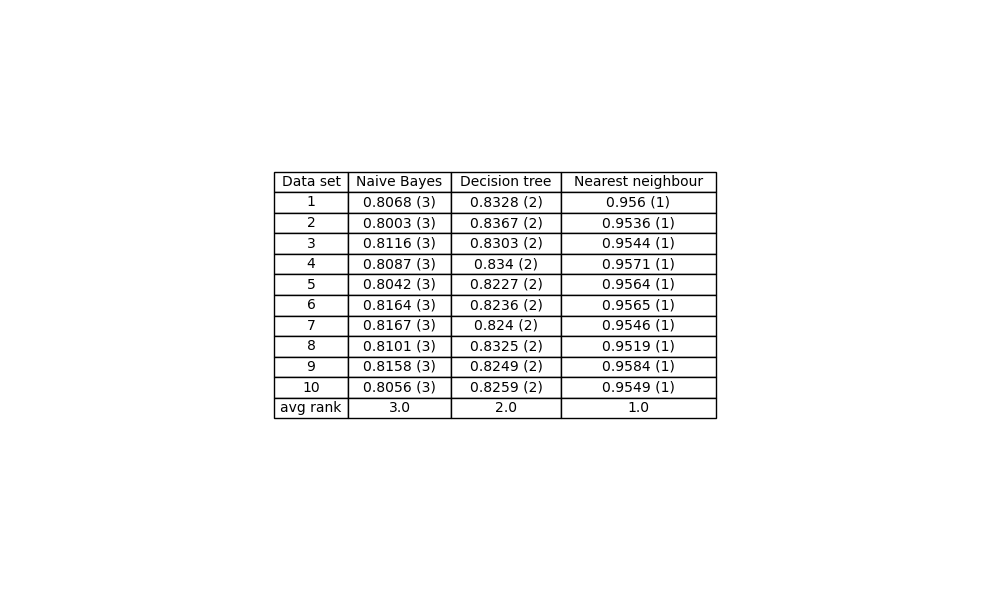

In [37]:
## Making a new Dataframe that looks like table 12.8 in main literature

gdb_string = []
rdf_string = []
knn_string = []

for i in range(len(ranks)):
    gdb_string.append(str(secs_gdb_f1_scores[i]) + " (" + str(ranks[i][0]) + ")")
    rdf_string.append(str(secs_rdf_f1_scores[i]) + " (" + str(ranks[i][1]) + ")")
    knn_string.append(str(secs_knn_f1_scores[i]) + " (" + str(ranks[i][2]) + ")")


data = {
    'Data set': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Naive Bayes': gdb_string,
    'Decision tree': rdf_string,
    'Nearest neighbour': knn_string,
}
avg = ['avg rank',secs_avg_gdb_f1_scores,secs_avg_rdf_f1_scores,secs_avg_knn_f1_scores]

plot = pd.DataFrame(data)
plot.loc[len(plot)] = avg

## Plotting the dataframe as a Table

fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_visible(False)
ax.axis('off')
table = ax.table(cellText=plot.values, colLabels=plot.columns, loc='center', cellLoc='center')
fig.tight_layout()
table.auto_set_column_width(col=list(range(len(plot.columns))))

### Conducting the Friedman and Nemenyi Tests

In [44]:
import math

# Declaring variables
k = 3
n = len(ranks)

## Calculating Friedman formulas
avg_rank = (k+1)/2
sum_sqd_secs = n * ((secs_avg_gdb_f1_scores - avg_rank)**2 + (secs_avg_rdf_f1_scores - avg_rank)**2 + (secs_avg_knn_f1_scores - avg_rank)**2)
sum_sqd_date = n * ((date_avg_gdb_f1_scores - avg_rank)**2 + (date_avg_rdf_f1_scores - avg_rank)**2 + (date_avg_knn_f1_scores - avg_rank)**2)


##Calculating Nemenyia Score
nem_score = 2.343 * (math.sqrt((k*(k+1)/(6*n))))

#Printing the results
print(f"The sum sqared difference for Dates: {sum_sqd_secs}")
print(f"The sum sqared difference for Secs: {sum_sqd_date}")
print(f"The Nemenyi Score: {nem_score}")

# Declaring variables
k = 2
n = len(ranks)

## Calculating Friedman formulas between modules
avg_rank = (k+1)/2
sum_sqd_date = n * ((secs_avg_rdf_f1_scores - avg_rank)**2 + (secs_avg_knn_f1_scores - avg_rank)**2)

##Calculating Nemenyia Score
nem_score = 2.343 * (math.sqrt((k*(k+1)/(6*n))))

print(f"\nThe sum sqared difference between Dates and Secs: {sum_sqd_date}")
print(f"The Nemenyi Score: {nem_score}")

The sum sqared difference for Dates: 20.0
The sum sqared difference for Secs: 20.0
The Nemenyi Score: 1.0478214542564015

The sum sqared difference between Dates and Secs: 5.0
The Nemenyi Score: 0.7409216557774513


### Model Stacking

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
model_a = RandomForestClassifier()
model_b = KNeighborsClassifier()

# Train base models
model_a.fit(date_X_train, date_y_train)
model_b.fit(secs_X_train, secs_y_train)

# Predictions for meta-model
pred_a = model_a.predict_proba(date_X_test)[:, 1]
pred_b = model_b.predict_proba(secs_X_test)[:, 1]
preda_a = model_a.predict(date_X_test)
preda_b = model_b.predict(secs_X_test)
stacked_features = np.column_stack((pred_a, pred_b))

# Meta-model
meta_model = LogisticRegression()
meta_model.fit(stacked_features, date_y_test)

# Evaluate
stacked_test_features = np.column_stack((
    model_a.predict_proba(date_X_test)[:, 1],
    model_b.predict_proba(secs_X_test)[:, 1]
))
final_predictions = meta_model.predict(stacked_test_features)
accuracy = round(f1_score(secs_y_test, preda_b),4)
accuracy1 = round(f1_score(date_y_test, preda_a),4)
accuracy2 = round(f1_score(secs_y_test, final_predictions),4)
print("Date model with Randomforest", accuracy)
print("Secs model with Nearest neighbour:", accuracy1)
print("Stacked Model:", accuracy2)

Date model with Randomforest 0.9727
Secs model with Nearest neighbour: 0.9556
Stacked Model: 0.9782
